In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

In [2]:
# Check for GPU
import tensorflow as tf
try:
    from google.colab import drive
    IN_COLAB=True
except:
    IN_COLAB=False

if IN_COLAB:
    print("We're running Colab")
else:
    print(tf.config.list_physical_devices())
    print('\nCUDA GPU: ' + str(tf.test.is_gpu_available(cuda_only=True)))

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.

CUDA GPU: True


In [3]:
df = pd.read_csv('./hourly02-ithaca/hourly02-NY_Ithaca_13_E.csv', header = 0, index_col = 0)
Date = pd.to_datetime(df.UTC_DATE, format='%Y%m%d', errors='coerce') + pd.to_timedelta(df.UTC_TIME//100, unit = 'hours')


In [4]:
data = df[['T_CALC', 'T_HR_AVG', 'T_MAX', 'T_MIN',
       'P_CALC', 'SOLARAD', 'SOLARAD_MAX',
       'SOLARAD_MIN', 'SUR_TEMP',
           'SUR_TEMP_MAX', 'SUR_TEMP_MIN', 'RH_HR_AVG']]
data.index = Date
# forward fill the missing values  
data.ffill(axis = 0, inplace = True) 
# drop NaN at the top
data.dropna(inplace = True)
# set target
data['target'] = data['T_HR_AVG']

In [5]:
data

,T_CALC,T_HR_AVG,T_MAX,T_MIN,P_CALC,SOLARAD,SOLARAD_MAX,SOLARAD_MIN,SUR_TEMP,SUR_TEMP_MAX,SUR_TEMP_MIN,RH_HR_AVG,target
2005-11-14 17:00:00,7.4,7.3,7.7,7.0,0.0,525.0,623.0,86.0,11.4,13.1,7.8,0.0,7.3
2005-11-14 18:00:00,7.4,7.3,7.7,7.0,0.0,463.0,581.0,89.0,11.1,13.0,8.7,0.0,7.3
2005-11-14 19:00:00,7.4,7.3,7.7,7.0,0.0,434.0,474.0,350.0,11.2,14.7,10.5,0.0,7.3
2005-11-14 20:00:00,8.4,8.7,8.9,8.4,0.0,293.0,387.0,84.0,9.6,11.1,7.0,0.0,8.7
2005-11-14 21:00:00,7.8,8.1,8.4,7.8,0.0,91.0,152.0,28.0,6.0,7.7,4.3,0.0,8.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-06 00:00:00,1.1,1.3,2.1,0.3,0.0,0.0,0.0,0.0,-1.6,-0.9,-2.0,76.0,1.3
2023-11-06 01:00:00,-0.1,0.0,1.0,-1.1,0.0,0.0,0.0,0.0,-2.3,-1.9,-2.8,80.0,0.0
2023-11-06 02:00:00,-0.5,-0.4,0.1,-0.7,0.0,0.0,0.0,0.0,-3.1,-2.8,-3.3,83.0,-0.4
2023-11-06 03:00:00,-1.4,-1.3,-0.5,-1.7,0.0,0.0,0.0,0.0,-3.2,-2.8,-3.5,85.0,-1.3


In [6]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(data, test_size=0.2, shuffle = False)

In [7]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(train)
train = scaler.transform(train)
test = scaler.transform(test)

In [8]:
# splitting data into sequences
def split_sequences(features, target, seq_len, forecast_len):
    X,y = list(), list()
    for i in range(len(features)):
        end_input = i + seq_len
        end_predict = end_input + forecast_len
        if end_predict > len(features)-1:
            break
        seq_x, seq_y = features[i:end_input,:], target[end_input:end_predict]
        X.append(seq_x)
        y.append(seq_y)
    return tf.convert_to_tensor(X, dtype=tf.float64), tf.convert_to_tensor(y, dtype=tf.float64)

In [9]:
# train period
input_X = data.iloc[len(train):len(train) + 40,:-1]
output_y = data.iloc[len(train) + 40:len(train) + 50,-1]

In [10]:
input_X

,T_CALC,T_HR_AVG,T_MAX,T_MIN,P_CALC,SOLARAD,SOLARAD_MAX,SOLARAD_MIN,SUR_TEMP,SUR_TEMP_MAX,SUR_TEMP_MIN,RH_HR_AVG
2020-04-02 02:00:00,0.8,1.2,2.0,0.7,0.0,0.0,0.0,0.0,-1.8,-1.3,-2.3,63.0
2020-04-02 03:00:00,0.3,0.5,0.8,0.2,0.0,0.0,0.0,0.0,-2.3,-2.2,-2.5,66.0
2020-04-02 04:00:00,-0.3,0.0,0.3,-0.3,0.0,0.0,0.0,0.0,-2.6,-2.3,-2.8,68.0
2020-04-02 05:00:00,-0.7,-0.4,-0.3,-0.7,0.0,0.0,0.0,0.0,-2.9,-2.8,-3.3,69.0
2020-04-02 06:00:00,-1.1,-0.9,-0.7,-1.1,0.0,0.0,0.0,0.0,-3.5,-3.2,-3.8,72.0
2020-04-02 07:00:00,-1.6,-1.4,-1.1,-1.6,0.0,0.0,0.0,0.0,-3.5,-3.4,-3.7,74.0
2020-04-02 08:00:00,-1.6,-1.5,-1.3,-1.6,0.0,0.0,0.0,0.0,-3.7,-3.5,-3.9,75.0
2020-04-02 09:00:00,-1.5,-1.7,-1.5,-1.9,0.0,0.0,0.0,0.0,-3.7,-3.4,-4.1,75.0
2020-04-02 10:00:00,-1.9,-1.7,-1.5,-1.9,0.0,0.0,0.0,0.0,-3.9,-3.6,-4.5,75.0
2020-04-02 11:00:00,-2.6,-2.4,-1.8,-2.9,0.0,0.0,0.0,0.0,-5.0,-4.4,-5.6,77.0


In [11]:
output_y

2020-04-03 18:00:00    4.4
2020-04-03 19:00:00    5.5
2020-04-03 20:00:00    5.8
2020-04-03 21:00:00    5.8
2020-04-03 22:00:00    5.9
2020-04-03 23:00:00    5.8
2020-04-04 00:00:00    5.2
2020-04-04 01:00:00    5.0
2020-04-04 02:00:00    4.8
2020-04-04 03:00:00    4.7
Name: target, dtype: float64

In [12]:
# load model
model1 = tf.keras.models.load_model('./LSTM/models/LSTM-FC_40-10')
model2 = tf.keras.models.load_model('./LSTM/models/BiLSTM-FC_40-10')

In [13]:
scaled_input_X = (np.array(input_X) - scaler.data_min_[:-1]) / scaler.data_range_[:-1]
pred1 = scaler.data_range_[-1] * model1.predict([scaled_input_X])[0] + scaler.data_min_[-1]
pred2 = scaler.data_range_[-1] * model2.predict([scaled_input_X])[0] + scaler.data_min_[-1]

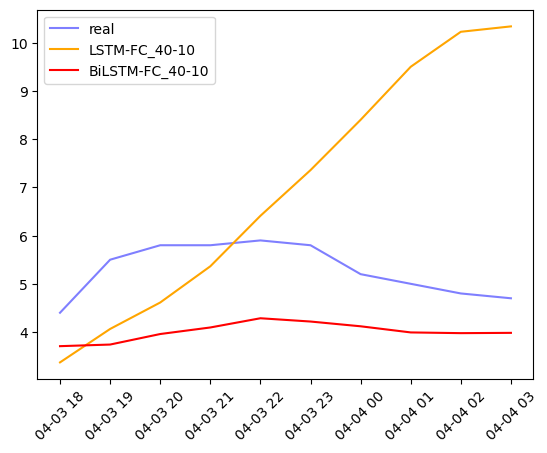

In [22]:
plt.plot(output_y, label = 'real', color = 'blue', alpha = 0.5)
#plt.plot(input_X.T_HR_AVG, label = 'real', color = 'blue', alpha = 0.5)
plt.plot(output_y.index, pred1, label = 'LSTM-FC_40-10', color = 'orange')
plt.plot(output_y.index, pred2, label = 'BiLSTM-FC_40-10', color = 'red')
plt.legend()
plt.xticks(rotation=45)
plt.show()